In [9]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import sys

In [2]:
df = pd.read_csv('airport.csv')
del df["time_of_day"]
del df["booth_rate"]

In [3]:
df["us"] = df["us_avg_wait"]
df["non_us"] = df["non_us_avg_wait"]

In [4]:
df['label'] = 0
for index, row in df.iterrows():
    if row['all_avg_wait']>15:
        df.at[index,'label'] = 1
    else:
        df.at[index,'label'] = 0

In [5]:
X = df.iloc[:,22:34]
y = df.iloc[:,-1] 

In [6]:
bestfeatures = SelectKBest(score_func=chi2, k=7)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(7,'Score'))  #print 10 best features

            Specs         Score
0      passengers  1.095464e+06
11         non_us  2.122630e+05
10             us  8.590340e+04
2          booths  2.476880e+03
1         flights  2.333207e+03
5   early morning  5.939148e+02
9    late evening  4.261540e+02


[0.07639022 0.02485004 0.0431301  0.00364888 0.00057581 0.01264003
 0.00409755 0.00521195 0.00837395 0.0057309  0.27976275 0.53558781]


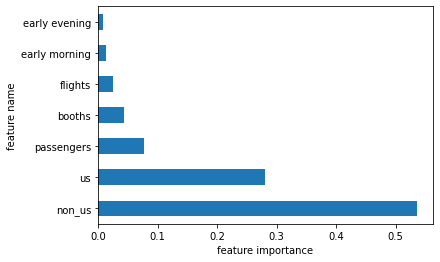

In [8]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(7).plot(kind='barh')
plt.xlabel('feature importance')
plt.ylabel('feature name')
plt.show()

In [5]:
X = df[[ "non_us", "us", "booths", "flights", "passengers"]].to_numpy()
y = df[['label']].to_numpy()
y = np.ravel(y)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [14]:
from sklearn.tree import DecisionTreeClassifier
tree_train_list = []
index = []
tree_test_list = []
for i in range(100):
    index.append(i+ 1)
    tree = DecisionTreeClassifier(max_depth=i + 1)
    tree.fit(X_train, y_train)
    tree_test_list.append(tree.score(X_test, y_test)) 
    tree_train_list.append(tree.score(X_train, y_train)) 

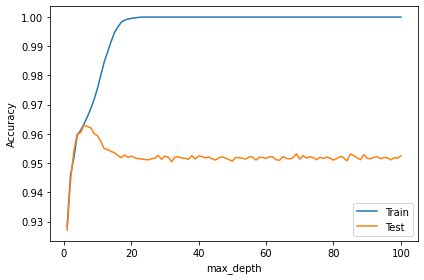

In [15]:
plt.plot(index, tree_train_list, label='Train')
plt.plot(index, tree_test_list, label='Test')
plt.legend(loc='best', numpoints=1)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.tight_layout()

In [16]:
from sklearn.model_selection import GridSearchCV
tree = DecisionTreeClassifier(random_state=123)

new_list = [None]
for i in range(20):
    new_list.append(i+1)
param_grid_tree = {
    'criterion': ['gini', 'entropy'],
    'max_depth': new_list
}

gs_tree = GridSearchCV(estimator=tree,
                  param_grid=param_grid_tree,
                  scoring='accuracy',
                  cv=10)

gs_tree.fit(X_train, y_train)

print('Best Accuracy: %.2f%%' % (gs_tree.best_score_*100))
print('Best Params: %s' % gs_tree.best_params_)
print('Test Accuracy: %.2f%%' % (gs_tree.best_estimator_.score(X_test, y_test)*100))

Best Accuracy: 96.06%
Best Params: {'criterion': 'gini', 'max_depth': 6}
Test Accuracy: 96.30%


In [17]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

cv_acc_tree = cross_val_score(estimator=gs_tree.best_estimator_,
                         X=X_train,
                         y=y_train,
                         cv=StratifiedKFold(n_splits=10, random_state=123, shuffle=True),
                         n_jobs=-1)

print('Kfold Accuracy: %.2f%%' % (np.mean(cv_acc_tree)*100))

from mlxtend.evaluate import bootstrap_point632_score


cv_acc_tree1 = bootstrap_point632_score(estimator=gs_tree.best_estimator_,
                                  X=X_train,
                                  y=y_train,
                                  random_seed=99)

print('OOB Bootstrap Accuracy: %.2f%%' % (np.mean(cv_acc_tree1)*100))

Kfold Accuracy: 96.09%
OOB Bootstrap Accuracy: 96.04%


In [18]:
y_pred_tree = gs_tree.best_estimator_.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix
tree_conf = confusion_matrix(y_test, y_pred_tree)
print(tree_conf)
print(classification_report(y_test, y_pred_tree))

[[9276  267]
 [ 271 4724]]
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      9543
           1       0.95      0.95      0.95      4995

    accuracy                           0.96     14538
   macro avg       0.96      0.96      0.96     14538
weighted avg       0.96      0.96      0.96     14538



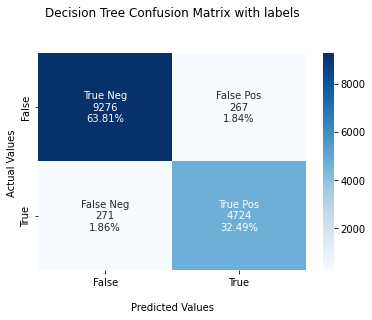

In [19]:
import seaborn as sns

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
tree_conf.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
tree_conf.flatten()/np.sum(tree_conf)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(tree_conf, annot=labels, fmt='', cmap='Blues')
ax.set_title('Decision Tree Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.
plt.show()

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=10, random_state=123)

param_grid_forest = {
    'criterion': ['gini', 'entropy'],
    'n_estimators': [10, 20, 50, 100, 150],
    'max_depth': [1, 10, 50, 100, 150]
}

gs_forest = GridSearchCV(estimator=forest,
                  param_grid=param_grid_forest,
                  scoring='accuracy',
                  cv=10)

gs_forest.fit(X_train, y_train)

print('Best Accuracy: %.2f%%' % (gs_forest.best_score_*100))
print('Best Params: %s' % gs_forest.best_params_)
print('Test Accuracy: %.2f%%' % (gs_forest.best_estimator_.score(X_test, y_test)*100))

Best Accuracy: 96.42%
Best Params: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 100}
Test Accuracy: 96.51%


In [21]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

cv_acc_forest = cross_val_score(estimator=gs_forest.best_estimator_,
                         X=X_train,
                         y=y_train,
                         cv=StratifiedKFold(n_splits=10, random_state=123, shuffle=True),
                         n_jobs=-1)

print('Kfold Accuracy: %.2f%%' % (np.mean(cv_acc_forest)*100))

from mlxtend.evaluate import bootstrap_point632_score


cv_acc_forest1 = bootstrap_point632_score(estimator=gs_forest.best_estimator_,
                                  X=X_train,
                                  y=y_train,
                                  random_seed=99)

print('OOB Bootstrap Accuracy: %.2f%%' % (np.mean(cv_acc_forest1)*100))

Kfold Accuracy: 96.36%
OOB Bootstrap Accuracy: 96.74%


In [22]:
y_pred_forest = gs_forest.best_estimator_.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix
forest_conf = confusion_matrix(y_test, y_pred_forest)
print(forest_conf)
print(classification_report(y_test, y_pred_forest))

[[9271  272]
 [ 236 4759]]
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      9543
           1       0.95      0.95      0.95      4995

    accuracy                           0.97     14538
   macro avg       0.96      0.96      0.96     14538
weighted avg       0.97      0.97      0.97     14538



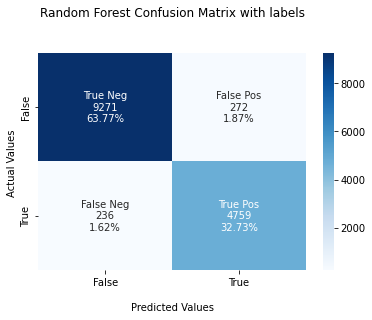

In [23]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
forest_conf.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
forest_conf.flatten()/np.sum(forest_conf)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(forest_conf, annot=labels, fmt='', cmap='Blues')
ax.set_title('Random Forest Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.
plt.show()

In [7]:
from sklearn.neighbors import KNeighborsClassifier

knn_train_list = []
index = []
knn_test_list = []
for i in range(100):
    index.append(i+ 1)
    pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier(n_neighbors=i + 1))])
    pipe.fit(X_train, y_train)
    knn_test_list.append(pipe.score(X_test, y_test)) 
    knn_train_list.append(pipe.score(X_train, y_train)) 

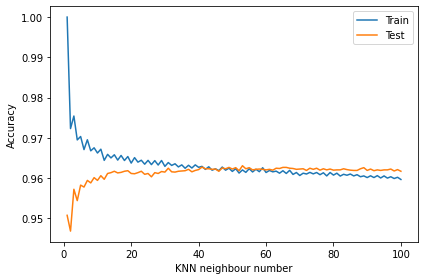

In [10]:
plt.plot(index, knn_train_list, label='Train')
plt.plot(index, knn_test_list, label='Test')
plt.legend(loc='best', numpoints=1)
plt.xlabel('KNN neighbour number')
plt.ylabel('Accuracy')
plt.tight_layout()

In [11]:
from sklearn.model_selection import GridSearchCV
pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])
new_list = []
for i in range(60):
    new_list.append(i+1)
param_grid = {
    'knn__n_neighbors': new_list
}

gs_knn = GridSearchCV(estimator=pipe,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=10)

gs_knn.fit(X_train, y_train)

print('Best Accuracy: %.2f%%' % (gs_knn.best_score_*100))
print('Best Params: %s' % gs_knn.best_params_)
print('Test Accuracy: %.2f%%' % (gs_knn.best_estimator_.score(X_test, y_test)*100))


Best Accuracy: 96.07%
Best Params: {'knn__n_neighbors': 23}
Test Accuracy: 96.17%


In [12]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

cv_acc_knn = cross_val_score(estimator=gs_knn.best_estimator_,
                         X=X_train,
                         y=y_train,
                         cv=StratifiedKFold(n_splits=10, random_state=123, shuffle=True),
                         n_jobs=-1)

print('Kfold Accuracy: %.2f%%' % (np.mean(cv_acc_knn)*100))

from mlxtend.evaluate import bootstrap_point632_score


cv_acc_knn1 = bootstrap_point632_score(estimator=gs_knn.best_estimator_,
                                  X=X_train,
                                  y=y_train,
                                  random_seed=99)

print('OOB Bootstrap Accuracy: %.2f%%' % (np.mean(cv_acc_knn1)*100))

Kfold Accuracy: 96.06%
OOB Bootstrap Accuracy: 95.98%


In [13]:
y_pred_knn = gs_knn.best_estimator_.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix
knn_conf = confusion_matrix(y_test, y_pred_knn)
print(knn_conf)
print(classification_report(y_test, y_pred_knn))

[[9316  227]
 [ 330 4665]]
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      9543
           1       0.95      0.93      0.94      4995

    accuracy                           0.96     14538
   macro avg       0.96      0.96      0.96     14538
weighted avg       0.96      0.96      0.96     14538



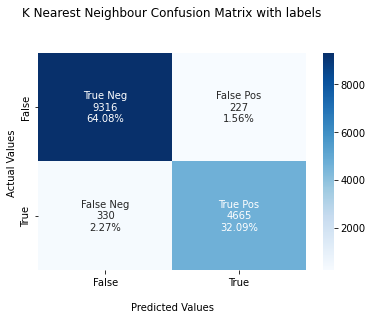

In [15]:
import seaborn as sns

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
knn_conf.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
knn_conf.flatten()/np.sum(knn_conf)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(knn_conf, annot=labels, fmt='', cmap='Blues')
ax.set_title('K Nearest Neighbour Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.
plt.show()

In [16]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

boost_train_list = []
index = []
boost_test_list = []
for i in range(30):
    index.append(i+ 1)
    boost = XGBClassifier(random_state=123, verbosity=0, use_label_encoder=False, max_depth = i +1)
    boost.fit(X_train, y_train)
    boost_test_list.append(boost.score(X_test, y_test)) 
    boost_train_list.append(boost.score(X_train, y_train)) 

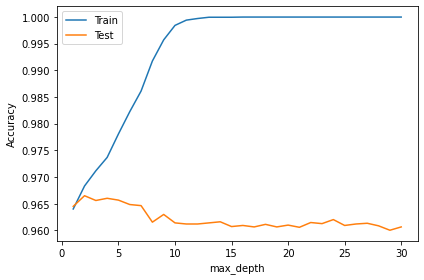

In [17]:
plt.plot(index, boost_train_list, label='Train')
plt.plot(index, boost_test_list, label='Test')
plt.legend(loc='best', numpoints=1)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.tight_layout()

In [19]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
boost = XGBClassifier(random_state=123, verbosity=0, use_label_encoder=False)

new_list = []
for i in range(8):
    new_list.append(i+1)
param_grid = {
    'max_depth': new_list,
    'learning_rate': [0.1, 0.01]
}

gs_boost = GridSearchCV(estimator=boost,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=10)

gs_boost.fit(X_train, y_train)

print('Best Accuracy: %.2f%%' % (gs_boost.best_score_*100))
print('Best Params: %s' % gs_boost.best_params_)
print('Test Accuracy: %.2f%%' % (gs_boost.best_estimator_.score(X_test, y_test)*100))

Best Accuracy: 96.61%
Best Params: {'learning_rate': 0.1, 'max_depth': 7}
Test Accuracy: 96.51%


In [20]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

cv_acc_boost = cross_val_score(estimator=gs_boost.best_estimator_,
                         X=X_train,
                         y=y_train,
                         cv=StratifiedKFold(n_splits=10, random_state=123, shuffle=True),
                         n_jobs=-1)

print('Kfold Accuracy: %.2f%%' % (np.mean(cv_acc_boost)*100))

from mlxtend.evaluate import bootstrap_point632_score


cv_acc_boost1 = bootstrap_point632_score(estimator=gs_boost.best_estimator_,
                                  X=X_train,
                                  y=y_train,
                                  random_seed=99)

print('OOB Bootstrap Accuracy: %.2f%%' % (np.mean(cv_acc_boost1)*100))

Kfold Accuracy: 96.47%
OOB Bootstrap Accuracy: 96.72%


In [21]:
y_pred_boost = gs_boost.best_estimator_.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix
boost_conf = confusion_matrix(y_test, y_pred_boost)
print(boost_conf)
print(classification_report(y_test, y_pred_boost))

[[9265  278]
 [ 229 4766]]
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      9543
           1       0.94      0.95      0.95      4995

    accuracy                           0.97     14538
   macro avg       0.96      0.96      0.96     14538
weighted avg       0.97      0.97      0.97     14538



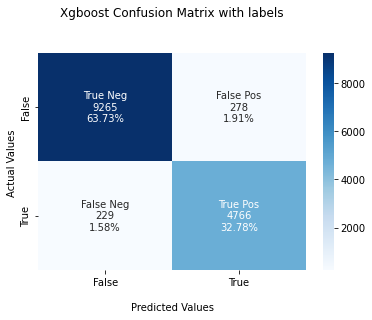

In [22]:
import seaborn as sns

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
boost_conf.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
boost_conf.flatten()/np.sum(boost_conf)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(boost_conf, annot=labels, fmt='', cmap='Blues')
ax.set_title('Xgboost Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.
plt.show()

In [23]:
from sklearn import svm
clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train)
y_pred_svm = clf.predict(X_test)

from sklearn import metrics

print("Accuracy:",metrics.accuracy_score(y_test, y_pred_svm))

Accuracy: 0.9588664190397579
